In [1]:
import pandas as pd
nba = pd.read_csv('../data/nba_2013.csv')

In [2]:
nba.shape

(481, 31)

In [3]:
nba.head(1)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013


In [4]:
pd.set_option('max_columns', 50)

In [5]:
nba.mean()

age             26.509356
g               53.253638
gs              25.571726
mp            1237.386694
fg             192.881497
fga            424.463617
fg.              0.436436
x3p             39.613306
x3pa           110.130977
x3p.             0.285111
x2p            153.268191
x2pa           314.332640
x2p.             0.466947
efg.             0.480752
ft              91.205821
fta            120.642412
ft.              0.722419
orb             55.810811
drb            162.817048
trb            218.627859
ast            112.536383
stl             39.280665
blk             24.103950
tov             71.862786
pf             105.869023
pts            516.582121
season_end    2013.000000
dtype: float64

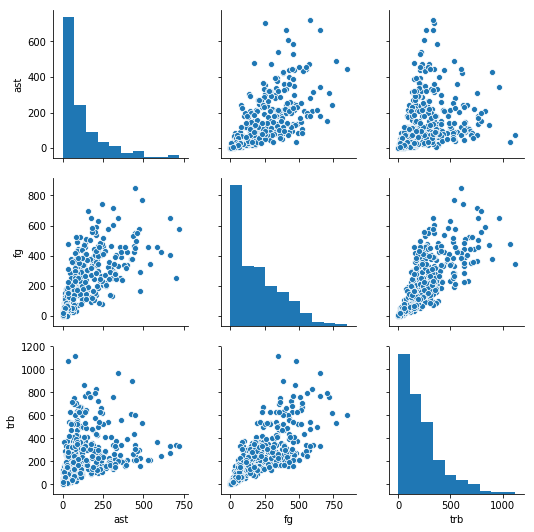

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.pairplot(nba[['ast', 'fg', 'trb']])
plt.show()

## Make clusters of players

In [7]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=5, random_state=1)
good_columns = nba._get_numeric_data().dropna(axis=1)
kmeans_model.fit(good_columns)

labels = kmeans_model.labels_

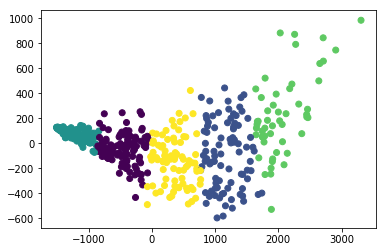

In [8]:
from sklearn.decomposition import PCA

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(good_columns)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
plt.show()

## Split into training and test datasets

In [10]:
train = nba.sample(frac=0.8, random_state=1)
test = nba.loc[~nba.index.isin(train.index)]

## Univariate Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[['fg']], train['ast'])
predictions = lr.predict(test[['fg']])

In [12]:
predictions

array([ 57.20764364, 264.85022463,  80.15466741,  91.90802106,
        95.8258056 ,  34.26061986,  61.68511169, 147.31668822,
       218.39649358, 193.77041928, 122.69061393,  79.59498391,
       135.56333458,  22.50726622, 196.00915331, 217.83681007,
        13.55233011, 174.18149654, 101.98232418, 147.31668822,
       240.78383384,   5.71676102, 297.31186802,  73.43846533,
        46.0139735 , 273.24547723, 480.32837472, 327.53477739,
       255.33560502,  40.97682194, 223.43364514,  48.25270753,
        71.19973131,  93.02738807,   6.83612803,  62.2447952 ,
       230.70953072,  36.49935389, 172.50244602,  34.82030337,
       298.43123504, 128.28744899,   7.95549505,  52.73017558,
       263.73085762, 160.18940888,  22.50726622,   8.51517855,
        51.05112506, 166.90561096, 132.20523354, 170.263712  ,
       292.27471646,  23.62663324, 203.8447224 ,  39.85745493,
       122.13093042,  56.08827663, 196.00915331, 254.21623801,
       143.39890367,   7.95549505, 166.34592745,  78.47

## Summary Statistics for the Model

In [13]:
import statsmodels.formula.api as sm

model = sm.ols(formula='ast ~ fga', data=train)
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ast   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     492.1
Date:                Wed, 14 Nov 2018   Prob (F-statistic):           1.03e-70
Time:                        11:00:24   Log-Likelihood:                -2273.3
No. Observations:                 385   AIC:                             4551.
Df Residuals:                     383   BIC:                             4559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.3302      6.855     -0.340      0.734     -15.808      11.147
fga            0.2712      0.012     22.183      0.000       0.247       0.295
==============================================================================
Omnibus:                      162.497   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.356
Skew:                           1.744   Prob(JB):                    3.67e-185
Kurtosis:                       9.386   Cond. No.                         847.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Fit a Random Forest Model

In [14]:
from sklearn.ensemble import RandomForestRegressor

predictor_columns = ["age", "mp", "fg", "trb", "stl", "blk"]
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=3)
rf.fit(train[predictor_columns], train["ast"])
predictions = rf.predict(test[predictor_columns])

### Calculate Error

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test['ast'], predictions)

5002.690785789244

## Web Data

In [16]:
import requests

url = 'http://www.basketball-reference.com/boxscores/201506140GSW.html'
data = requests.get(url).content

In [17]:
from bs4 import BeautifulSoup
import re

soup = BeautifulSoup(data, 'html.parser')
box_scores = []
for tag in soup.find_all(id=re.compile("[A-Z]{3,}_basic")):
    rows = []
    for i, row in enumerate(tag.find_all("tr")):
        if i == 0:
            continue
        elif i == 1:
            tag = "th"
        else:
            tag = "td"
        row_data = [item.get_text() for item in row.find_all(tag)]
        rows.append(row_data)
    box_scores.append(rows)

In [18]:
box_scores

[]